# Notebook referente ao exercício 2.2.3 - Crank-Nicolson

## Problema Misto — Equação Paraxial com Crank-Nicolson

Queremos resolver numericamente o problema misto para a equação paraxial no domínio:

$$\Omega = \{(x,z) \mid x \in [0, 3000],\; z \in [0, 500]\}$$

Vamos considerar a seguinte equação paraxial

$$i\,u_x + b\,u_{zz} + V\,u = 0$$

onde os coeficientes são,

$$b = 5, \qquad V(z) = \exp\!\left(-\frac{(z-250)^2}{30000}\right)$$

Além disso, definimos as seguintes condições de contorno e condição inicial

$$u(x, 0) = u(x, L) = 0, \quad \text{onde } L = 500$$

$$u(0, z) = u_0(z) =  \exp\!\left(\frac{iz}{4}\right)\exp\!\left(-\frac{(z-250)^2}{1500}\right)$$

Utilizaremos os seguintes valores para o passo
$$\Delta x = 5, \qquad \Delta z = 1.$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Definamos as variáveis que o problemas nos dá

xmax = 3000 
zmax = 500

dx = 5
dz = 1
nx = int(xmax/dx) # n° de pontos do stencil em x
nz = int(zmax/dz) # n° de pontos do stencil em y
sx = np.linspace(0,xmax,nx)
sz = np.linspace(0,zmax,nz)

x,z = np.meshgrid(sx,sz) # nossa grade

def V(z): # potencial
    return np.exp(-(z - 250)**2 / 30000) 

def cond_in(z): # condição inicial
    return np.exp(1j * z / 4) * np.exp(-((z - 250)**2) / 1500)

b = 5

Sabemos que no esquema de Crank-Nicholson, podemos encontrar uma recorrência da seguinte maneira

$$A\mathbf{u_{n+1}} = B\mathbf{u_{n}}$$

onde podemos escrever $u_{k}$ como, 

$$\mathbf{u_{k}}=\begin{pmatrix} u_{k,0} \\ u_{k,1} \\ u_{k,2} \\ \vdots \\ u_{k,m} \end{pmatrix}$$

onde o primeiro índice representa a coordenada $x_n$, e o segundo a coordenada $z_j$.

Além disso, as matrizes $A$ e $B$ são matrizes tri-diagonais que obtemos a partir da equção paraxial do esquema que estamos usando.

Resolvendo o esquema, encontramos as seguintes matrizes,

$$
A = \begin{pmatrix}
1 & 0 &        &        & 0      \\
\frac{b}{2\Delta z^2} & \frac{i}{\Delta x}-\frac{b}{\Delta z^2}+\frac{V(z_1)}{2} & \frac{b}{2\Delta z^2}      &        &        \\
  & \frac{b}{2\Delta z^2} & \frac{i}{\Delta x}-\frac{b}{\Delta z^2} +\frac{V(z_2)}{2}     & \ddots &        \\
  &   & \ddots & \ddots & \frac{b}{2\Delta z^2}      \\
0 &   &        & 0      & 1
\end{pmatrix}
$$

e

$$
B = \begin{pmatrix}
1 & 0 &        &        & 0      \\
-\frac{b}{2\Delta z^2} & \frac{i}{\Delta x}+\frac{b}{\Delta z^2}-\frac{V(z_1)}{2} & -\frac{b}{2\Delta z^2}      &        &        \\
  & -\frac{b}{2\Delta z^2} & \frac{i}{\Delta x}+\frac{b}{\Delta z^2}-\frac{V(z_2)}{2}      & \ddots &        \\
  &   & \ddots & \ddots & -\frac{b}{2\Delta z^2}      \\
0 &   &        & 0     & 1
\end{pmatrix}
$$

In [16]:

def matrices(b, dx, dz, V_func, z_grid):
    """
    Constrói as matrizes tridiagonais A e B do para
    o nosso problema.
    """

    N = len(z_grid)
    r = b / (2 * dz**2)      
    V = V_func(z_grid)   # avalia V nos pontos internos

    diag_A = np.array([1.0] +
                      [1j/dx - 2*r + V[k]/2 for k in range(1, N-1)] +
                      [1.0])

    diag_B = np.array([1.0] +
                      [1j/dx + 2*r - V[k]/2 for k in range(1, N-1)] +
                      [1.0])

    sup_A = np.array([0] +                         
                    [r for _ in range(N-2)])

    sub_A = np.array([r for _ in range(N-2)] +
                    [0])    

    sup_B = np.array([0] +                         
                 [-r for _ in range(N-2)])

    sub_B = np.array([-r for _ in range(N-2)] +
                 [0])    

    # Monta as matrizes 
    A = (np.diag(diag_A, k=0) +
         np.diag(sup_A,  k=1) +
         np.diag(sub_A,  k=-1))

    B = (np.diag(diag_B, k=0) +
         np.diag(sup_B,  k=1) +
         np.diag(sub_B,  k=-1))

    return A, B

A , B = matrices(b,dx,dz,V,sz)



Para resolver esse problema, eu pesquisei um pouco como que se resolve um sistema de esquações em python. Com isso, encontrei o algoritmo de Thomas para resolver o problema. Ele se consiste basicamente em achar as soluções a partir da recursão da matriz tridiagonal a partir dos coeficientes dela

In [17]:
def thomas(subd, diag, supd, u_n):
    """
    Resolve o sistema tridiagonal A·x = d pelo Algoritmo de Thomas.

    Parâmetros:
        a : subdiagonal   (tamanho N-1) — abaixo da diagonal principal
        b : diagonal      (tamanho N)   — diagonal principal
        c : superdiagonal (tamanho N-1) — acima da diagonal principal
        d : vetor do lado direito (tamanho N)

    Retorna:
        x : solução do sistema (tamanho N)
    """

    N = len(u_n)

    # Cópias para não modificar os originais
    c_ = np.zeros(N-1, dtype=complex)
    d_ = np.zeros(N,   dtype=complex)
    x  = np.zeros(N,   dtype=complex)

    # --- Forward sweep ---
    c_[0] = supd[0] / diag[0]
    d_[0] = u_n[0] / diag[0]

    for i in range(1, N):
        denom = diag[i] - subd[i-1] * c_[i-1]
        d_[i] = (u_n[i] - subd[i-1] * d_[i-1]) / denom
        if i < N-1:
            c_[i] = supd[i] / denom

    # --- Back substitution ---
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i] * x[i+1]

    return x

In [18]:
u = np.zeros((nx, nz), dtype=complex)
u[0, :] = cond_in(sz)

diag_A = np.diag(A, k=0)
sup_A  = np.diag(A, k=1)
sub_A  = np.diag(A, k=-1)

# Recursão
for n in range(nx - 1):
    ld = B @ u[n, :]   # lado direito
    u[n+1, :] = thomas(sub_A, diag_A, sup_A, ld)

Para visualizar graficamente o comportamento de nossa solução (como se propaga), podemos construir um mapa de intensidade que determina o valor de $|u(x,z)^2|$ em para cada ponto de nossa grade.

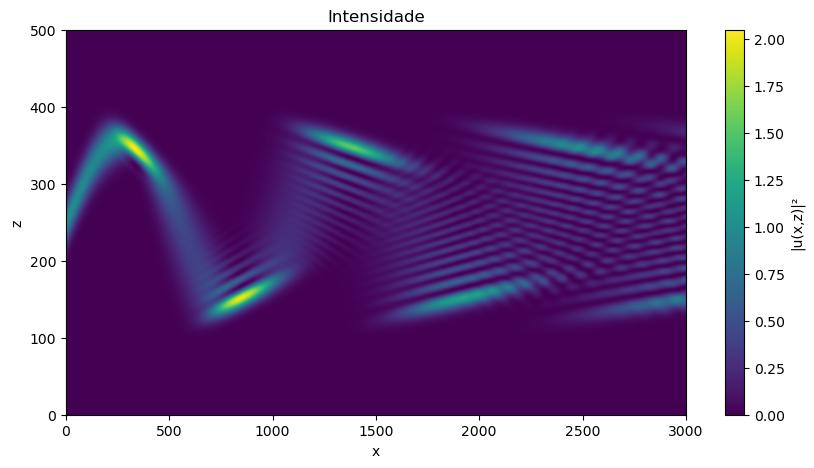

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(u).T**2, aspect='auto', origin='lower',
           extent=[0, xmax, 0, zmax])
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(label='|u(x,z)|²')
plt.title('Intensidade')
plt.show()

-----
Comentar
-----

Além disso, podemos ver como é o perfil da nossa função para um z fixo, ou para um x fixo.

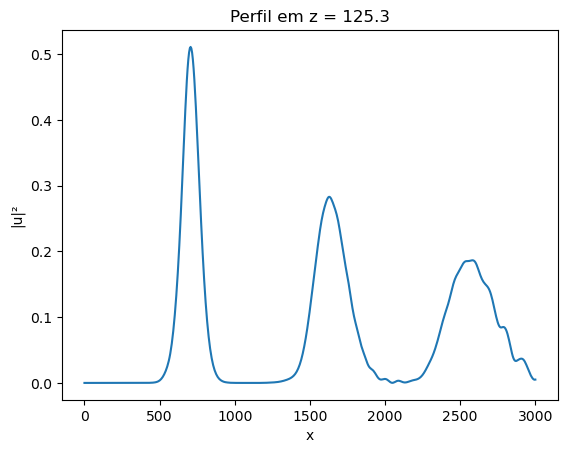

In [43]:
n = 125  # índice do passo em z que queremos fixar

plt.plot(sx, np.abs(u[:, n])**2)
plt.xlabel('x')
plt.ylabel('|u|²')
plt.title(f'Perfil em z = {sz[n]:.1f}')
plt.show()

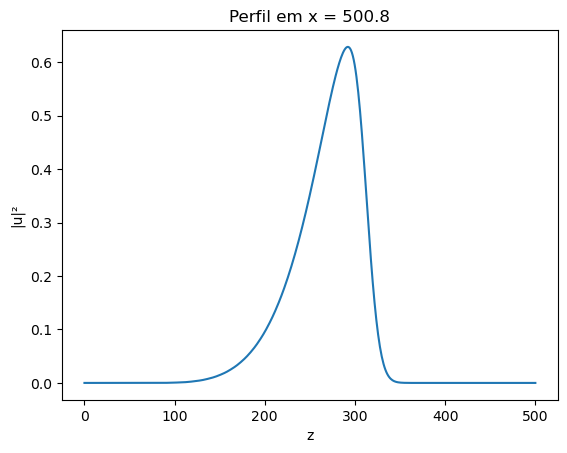

In [61]:
m = 500  # índice do passo em z que queremos fixar

plt.plot(sz, np.abs(u[int(m/5), :])**2)
plt.xlabel('z')
plt.ylabel('|u|²')
plt.title(f'Perfil em x = {sx[int(m/5)]:.1f}')
plt.show()

-----
Comentar
-----